In [ ]:
#| default_exp extract_semb

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
import torchaudio

from pathlib import Path
from fastprogress import progress_bar, master_bar
from fastcore.script import *

import whisper
from whisperspeech.extract_acoustic import load

In [ ]:
# unpacked small.tar should go here:
datadir = Path('/mnt/')
# you can download it downloaded from
# https://github.com/facebookresearch/libri-light/blob/main/data_preparation/README.md

# Extract Whisper embeddings and token lists

For distillation with an autoregressive (AR) decoder we need to know the ground truth text tokens. We also need logits but they are extremely large (there are 15k+ text tokens) so we store the token indices instead and run them through the decoder at train time twice (once with raw encoder embeddings and once with quantized).

In [ ]:
#| export
def load_model():
    return whisper.load_model('tiny.en')

In [ ]:
whmodel = load_model()

In [ ]:
whmodel

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0): ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=384, out_features=384, bias=True)
          (key): Linear(in_features=384, out_features=384, bias=False)
          (value): Linear(in_features=384, out_features=384, bias=True)
          (out): Linear(in_features=384, out_features=384, bias=True)
        )
        (attn_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1536, out_features=384, bias=True)
        )
        (mlp_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): Mult

Let's implement this step by step first:

In [ ]:
# load an audio file
audio = load(datadir/'small/200/spy_cooper_librivox_64kb_mp3/spy_05_cooper_64kb.flac',
             newsr=whisper.audio.SAMPLE_RATE)

In [ ]:
# we start with the mel spectrogram
mel = whisper.log_mel_spectrogram(audio[0,0])

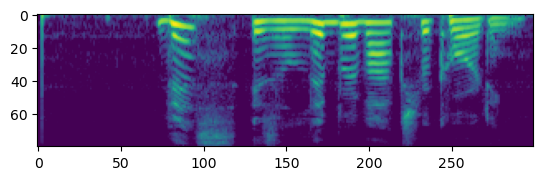

In [ ]:
# let's see how a spectrogram of speech looks like
import pylab as plt
plt.imshow(mel[:,:300].cpu());

In [ ]:
whmodel.encoder.ln_post = torch.nn.Identity()
#del whmodel.encoder.blocks[3]
del whmodel.encoder.blocks[2]
whmodel.encoder

AudioEncoder(
  (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
  (blocks): ModuleList(
    (0): ResidualAttentionBlock(
      (attn): MultiHeadAttention(
        (query): Linear(in_features=384, out_features=384, bias=True)
        (key): Linear(in_features=384, out_features=384, bias=False)
        (value): Linear(in_features=384, out_features=384, bias=True)
        (out): Linear(in_features=384, out_features=384, bias=True)
      )
      (attn_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=384, out_features=1536, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1536, out_features=384, bias=True)
      )
      (mlp_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
    (1): ResidualAttentionBlock(
      (attn): MultiHeadAttention(
        (query): Linear(in_features=384, out_f

In [ ]:
# get float embeddings vectors for this spectrogram
start = 0
sample = mel[:,:3000]
with torch.no_grad():
    # we have to pad (or trim) the input so it's exactly 30 seconds long
    padded = whisper.audio.pad_or_trim(sample, whisper.audio.N_FRAMES).unsqueeze(0)
    emb = whmodel.encoder(padded)#[0,:sample.shape[-1]//2].cpu()

In [ ]:
sample.shape

torch.Size([80, 3000])

In [ ]:
padded.shape

torch.Size([1, 80, 3000])

In [ ]:
emb.shape

torch.Size([1, 1500, 384])

In [ ]:
# we use the Whisper decoding algorithm to get the text tokens (integer numbers)
tokens = whmodel.decode(padded, whisper.DecodingOptions(language='en', suppress_blank=False, suppress_tokens=False))[0].tokens
len(tokens)

1

In [ ]:
# to decode these embeddings into text we need to prompt the model with some special tokens
# we can get them from the tokenizer and prepend them to the token list
tokenizer = whisper.tokenizer.get_tokenizer(False, language='en')

In [ ]:
# afterwards we can pass in the whole token list through the model to get the logits
logits = whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda(), emb)
# these are probabilities of each token at each timestep so there are 52k numbers for each output token
logits.shape

torch.Size([1, 65, 51864])

And verify it decodes successfully:

In [ ]:
tokens = torch.tensor(tokens)
tokens

tensor([50363,   770,   318,   257,  7980,   430, 28035,  8296,    13,  1439,
         7980,   430, 28035, 18813,   389,   287,   262,  1171,  7386,    13,
        50713, 50713,  1114,   517,  1321,   290,   284,  1064,   503,   703,
          345,   460, 13904,    11,  3387,  3187,  7980,   430,    85,  1140,
           13,  2398,    13, 51063, 51063, 43905,   416, 11000,   440,     6,
        20118,    13, 51263, 51263, 14200,   801,  8609,    13,  6404, 20485,
           13,   785, 51513, 51513])

In [ ]:
tokenizer.decode(tokens)

" This is a Libra Vox recording. All Libra Vox recordings are in the public domain. For more information and to find out how you can volunteer, please visit Libravox.org. Recording by Marine O'Brien. Marialectrix.logspot.com"

In [ ]:
logits.argmax(-1)

tensor([[50361,   770,   318,   257,  7980,   430, 28035,  8296,    13,  1439,
          7980,   430, 28035, 18813,   389,   287,   262,  1171,  7386,    13,
          1114, 50713,  1114,   517,  1321,   290,   284,  1064,   503,   703,
           345,   460, 13904,    11,  3387,  3187,  7980,   430,    85,  1140,
            13,  2398,    13, 51063, 51063, 43905,   416, 11000,   440,     6,
         20118,    13, 51263, 51263, 14200,   801,  8609,    13,  6404, 20485,
            13,   785, 51513, 51513, 50256]], device='cuda:0')

In [ ]:
tokenizer.decode(logits.argmax(-1)[0])

"<|nospeech|> This is a Libra Vox recording. All Libra Vox recordings are in the public domain. For For more information and to find out how you can volunteer, please visit Libravox.org. Recording by Marine O'Brien. Marialectrix.logspot.com<|endoftext|>"

In [ ]:
# They are the same (apart from the first token for some reason; let's ignore this for now)
tokenizer.decode([50363]), tokenizer.decode([50361])

('', '<|nospeech|>')

In [ ]:
#| export
# same as above but rolled into a function
def encode_semantic(whmodel, audio):
    """Encode the given `audio` (tensor or file name) into Whisper embeddings and lists of text tokens.
    Uses the given `whmodel` (see `load_model`).
    """
    if isinstance(audio, (Path, str)):
        audio = load(audio, newsr=whisper.audio.SAMPLE_RATE)
    mel = whisper.log_mel_spectrogram(audio[0,0])
    embs = []
    toks = []
    for start in range(0, mel.shape[-1], whisper.audio.N_FRAMES):
        sample = mel[:,start:]
        with torch.no_grad():
            padded = whisper.audio.pad_or_trim(sample, whisper.audio.N_FRAMES).unsqueeze(0)
            emb = whmodel.encoder(padded)
            tokens = whmodel.decode(emb, whisper.DecodingOptions(language='en', suppress_blank=False, suppress_tokens=False))[0].tokens
            embs.append(emb.cpu())
            toks.append(tokens)
    return torch.stack(embs, axis=0), toks

In [ ]:
embs, toks = encode_semantic(whmodel, datadir/'small/200/spy_cooper_librivox_64kb_mp3/spy_05_cooper_64kb.flac')
embs.shape, len(toks)

(torch.Size([52, 1, 1500, 384]), 0)

In [ ]:
#| export
@call_parse
def extract_semantic(
        srcdir:Path,  # source dir, should contain *.flac files
        outdir:Path,  # output dir, will get the *.semb and *.ttoks files
        layer='last', # the layer to extract the embeddings from
    ): 
    "Convert audio files to .semb files with Whisper embeddings and .ttoks with text tokens"
    model = load_model()
    suffix = '.semb'
    
    if layer != 'last':
        layer = int(layer)
        N = len(model.encoder.blocks)
        for i in range(N,layer,-1):
            print("Removing layer", i)
            del model.encoder.blocks[i-1]
        model.encoder.ln_post = torch.nn.Identity()
        suffix += f'-{layer}'
    
    outdir.mkdir(exist_ok=True, parents=True)
    for name in progress_bar(list(srcdir.rglob('*.flac'))):
        embs, toks = encode_semantic(model, name)
        torch.save(embs, outdir/name.with_suffix(suffix).name)
        torch.save(toks, outdir/name.with_suffix('.ttoks').name)

In [ ]:
# extract all embeddings for a couple of speakers
speakers = [1649]
#speakers = [1649, 2156, 1901, 2607, 2234, 1743, 1614, 3657, 204, 3488, 19, 107, 2162, 1212, 4174]

# a faster version: parallel --eta -j10 spear_extract_semantic /mnt/small/{} /mnt/semantic-small/{} ::: 1649 2156 1901 2607 2234 1743 1614 3657 204 3488 19 107 2162 1212 4174
mb = master_bar(speakers)
for spkid in mb:
    extract_semantic(datadir/'small'/str(spkid), datadir/'semantic-small'/str(spkid), layer=2)

Removing layer 4
Removing layer 3


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()